In [2]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2024-09-22 17:56:54.902419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 17:56:54.914121: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 17:56:54.917563: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 17:56:54.926190: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-22 17:56:55.535008: W tensorflow/compiler/tf2

# Specify each path

In [3]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [4]:
NUM_CLASSES = 30

In [5]:
NUM_CLASSES = 30

# Dataset reading

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [7]:
NUM_CLASSES = 30

In [8]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [10]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (7627, 42)
y_train shape: (7627,)
X_test shape: (2543, 42)
y_test shape: (2543,)


# Model building

In [11]:
print('shape:', X_train.shape[1:])

model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )), # had to change for the two handed gestures
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

shape: (42,)


2024-09-22 17:56:56.690431: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-09-22 17:56:56.690451: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: pop-os
2024-09-22 17:56:56.690456: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: pop-os
2024-09-22 17:56:56.690542: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 560.35.3
2024-09-22 17:56:56.690557: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 560.35.3
2024-09-22 17:56:56.690561: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 560.35.3


In [29]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,400 (5.47 KB)

 Trainable params: 1,400 (5.47 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [14]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [15]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/60 ━━━━━━━━━━━━━━━━━━━━ 30s 509ms/step - accuracy: 0.0156 - loss: 3.5552
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0316 - loss: 3.4423 - val_accuracy: 0.0201 - val_loss: 3.2605
Epoch 2/1000
 1/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0469 - loss: 3.2847
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.0703 - loss: 3.2424 - val_accuracy: 0.1038 - val_loss: 2.9776
Epoch 3/1000
 1/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0781 - loss: 3.0622
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.1211 - loss: 3.0105 - val_accuracy: 0.2092 - val_loss: 2.8066
Epoch 4/1000
 1/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1562 - loss: 2.9369
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier

In [16]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.8223 - loss: 1.0524


In [17]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [18]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[2.1480275e-03 9.6367476e-05 1.2051779e-02 1.2866242e-06 6.9877811e-02
 1.3623388e-03 5.9015942e-03 2.6561772e-02 8.8254260e-03 1.3583695e-03
 8.8101968e-02 1.3158037e-02 2.8404600e-03 1.7688301e-06 2.7096739e-02
 4.2729303e-01 2.5158340e-02 1.8780464e-02 5.3417180e-03 4.6222941e-03
 6.7249173e-03 1.1983786e-02 2.5488151e-02 1.1003336e-01 1.5760658e-02
 1.5459144e-02 4.5545525e-03 5.7441425e-02 1.0755961e-02 1.2185017e-03]
15


# Confusion matrix

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


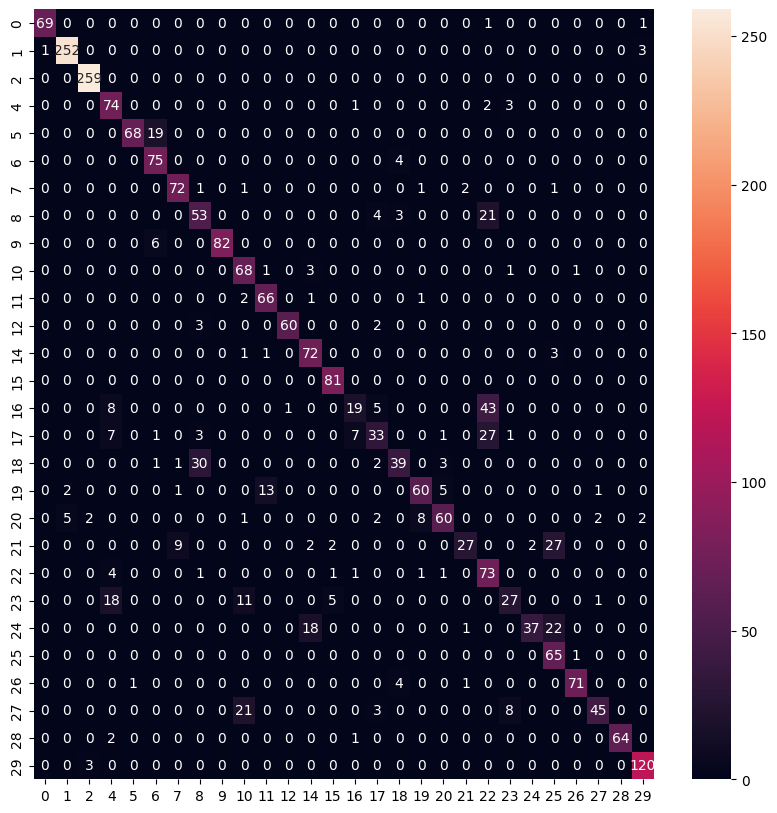

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.97      0.98      0.98       256
           2       0.98      1.00      0.99       259
           4       0.65      0.93      0.77        80
           5       0.99      0.78      0.87        87
           6       0.74      0.95      0.83        79
           7       0.87      0.92      0.89        78
           8       0.58      0.65      0.62        81
           9       1.00      0.93      0.96        88
          10       0.65      0.92      0.76        74
          11       0.81      0.94      0.87        70
          12       0.98      0.92      0.95        65
          14       0.75      0.94      0.83        77
          15       0.91      1.00      0.95        81
          16       0.66      0.25      0.36        76
          17       0.65      0.41      0.50        80
          18       0.78      0.51      0.62        76
     

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )), # had to change for the two handed gestures
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Convert to model for Tensorflow-Lite

In [21]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [22]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpmsfk_uiv/assets


INFO:tensorflow:Assets written to: /tmp/tmpmsfk_uiv/assets


Saved artifact at '/tmp/tmpmsfk_uiv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='keras_tensor_21')
Output Type:
  TensorSpec(shape=(None, 30), dtype=tf.float32, name=None)
Captures:
  126390376411216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126390376412368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126390376412560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126390376413136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126390376413328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126390376413904: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1726991828.257655  235409 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1726991828.257679  235409 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-09-22 17:57:08.257939: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmsfk_uiv
2024-09-22 17:57:08.258262: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-09-22 17:57:08.258274: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpmsfk_uiv
2024-09-22 17:57:08.261010: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-09-22 17:57:08.261501: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-09-22 17:57:08.276002: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpmsfk_uiv
2024-09-22 17:57:08.282397: I tensorflow/cc/saved_model/loader.cc

7192

# Inference test

In [23]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [24]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [25]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [26]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 548 μs, sys: 75 μs, total: 623 μs
Wall time: 316 μs


In [27]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.03731177 0.04520183 0.03054992 0.0298964  0.04410464 0.02421124
 0.03097917 0.01881595 0.04182179 0.03078057 0.02674186 0.04251844
 0.03538595 0.03230699 0.04628977 0.02131914 0.03939939 0.04031178
 0.03750169 0.0220943  0.02721818 0.02737861 0.02472191 0.04353491
 0.02203204 0.04175809 0.03379333 0.03093653 0.02898146 0.04210244]
14
